# TP2- Modelo con estructura XGBoost

## Set up inicial

In [1]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

## Carga de datos

Se cargan las columnas con formatos adecuados según el tipo de datos. Se usa como índice building_id

In [2]:
# Train values
# Levantar los datos de cada edificio/casa
df = pd.read_csv('datos/train_values.csv',nrows=0)
columnas = df.columns.to_list()
datatypes = {
    **{columnas[0]:np.int32}\
    , **{column:np.int16 for column in columnas[1:8] + columnas[27:28]}\
    , **{column:'category' for column in columnas[8:15] + columnas[26:27]}\
    , **{column:np.bool for column in columnas[15:26] + columnas[28:39]}
}
train_values = pd.read_csv('datos/train_values.csv',dtype=datatypes)
train_values = train_values.set_index("building_id")

In [3]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          260601 non-null  int16   
 1   geo_level_2_id                          260601 non-null  int16   
 2   geo_level_3_id                          260601 non-null  int16   
 3   count_floors_pre_eq                     260601 non-null  int16   
 4   age                                     260601 non-null  int16   
 5   area_percentage                         260601 non-null  int16   
 6   height_percentage                       260601 non-null  int16   
 7   land_surface_condition                  260601 non-null  category
 8   foundation_type                         260601 non-null  category
 9   roof_type                               260601 non-null  category
 10  ground_floor_type          

In [4]:
# train_values = pd.read_csv('datos/train_values.csv',index_col='building_id')

In [5]:
train_values.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
28830,8,900,2812,2,10,8,7,o,r,n,...,False,False,False,False,False,False,False,False,False,False
94947,21,363,8973,2,10,5,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
590882,22,418,10694,2,10,6,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
201944,11,131,1488,3,30,8,9,t,r,n,...,False,False,False,False,False,False,False,False,False,False


In [6]:
#Train labels
train_labels = pd.read_csv('datos/train_labels.csv',index_col='building_id')

In [7]:
train_labels.head()

,damage_grade
building_id,
802906,3
28830,2
94947,3
590882,2
201944,3


<AxesSubplot:title={'center':'Number of Buildings with Each Damage Grade'}>

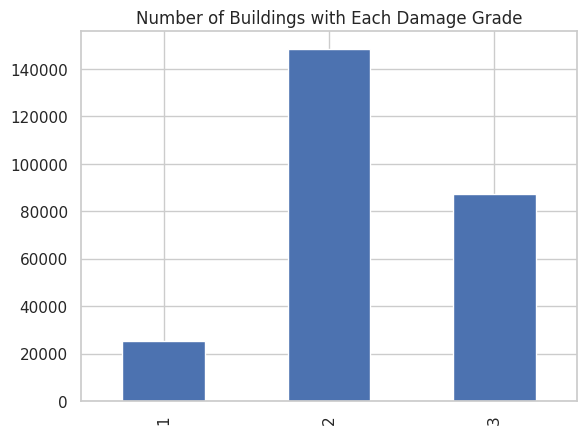

In [8]:
(train_labels.damage_grade
             .value_counts()
             .sort_index()
             .plot.bar(title="Number of Buildings with Each Damage Grade"))

In [9]:
selected_features = [columnas[1]] + columnas[4:13] + columnas[14:25] + [columnas[28]]
#selected_features
train_values_subset = train_values[selected_features]

In [10]:
train_values_subset.head()

,geo_level_1_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,...,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_secondary_use
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,2,30,6,5,t,r,n,f,q,...,True,False,False,False,False,False,False,False,False,False
28830,8,2,10,8,7,o,r,n,x,q,...,True,False,False,False,False,False,False,False,False,False
94947,21,2,10,5,5,t,r,n,f,x,...,True,False,False,False,False,False,False,False,False,False
590882,22,2,10,6,5,t,r,n,f,x,...,True,False,False,False,False,True,True,False,False,False
201944,11,3,30,8,9,t,r,n,f,x,...,False,False,False,False,False,False,False,False,False,False


## Preprocessing the data

In [11]:
## Convierte las variables categóricas en columnas booleanas a 0 o 1. 
## Por ej land_surface_condition tiene 3 tipos: n, o, t. Se crean 3 columnas para cada registro y según sea n,o,t va a tener 1 en la respectiva columna y 0 en las otras 2.
train_values_subset = pd.get_dummies(train_values_subset)

In [12]:
train_values_subset.head()

,geo_level_1_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,...,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,2,30,6,5,True,True,False,False,False,...,0,0,1,0,0,0,0,0,0,0
28830,8,2,10,8,7,False,True,False,False,False,...,0,0,1,0,0,0,0,0,0,0
94947,21,2,10,5,5,False,True,False,False,False,...,0,0,1,0,0,0,0,0,0,0
590882,22,2,10,6,5,False,True,False,False,False,...,0,0,1,0,0,0,0,0,0,0
201944,11,3,30,8,9,True,False,False,False,False,...,0,0,1,0,0,0,0,0,0,0


In [13]:
import xgboost as xgb

In [28]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob",learning_rate=0.3,max_depth=10,random_state=99)
xgb_model.fit(train_values_subset,train_labels.values.ravel() )

[16:15:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=99, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [29]:
from sklearn.metrics import f1_score
y_pred = xgb_model.predict(train_values_subset)
f1_score(train_labels, y_pred, average='micro')

0.7510715615059036

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

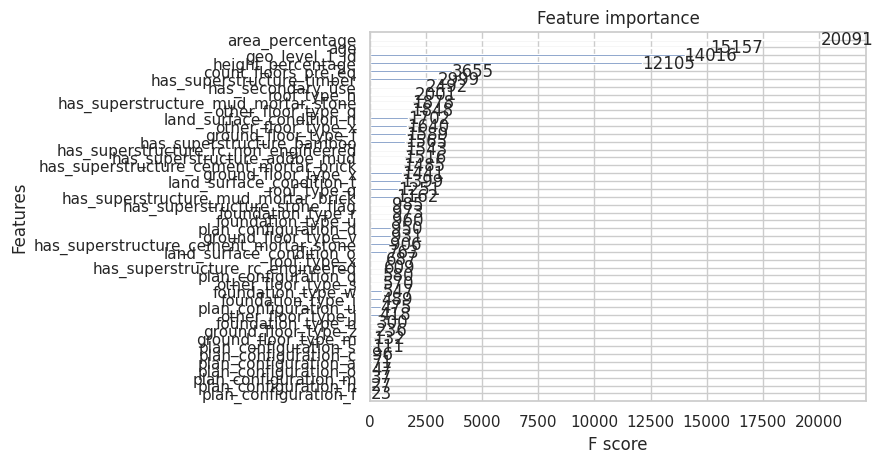

In [39]:
xgb.plot_importance(xgb_model)

## Time to Predict and Submit

In [40]:
test_values = pd.read_csv('datos/test_values.csv', index_col='building_id')

In [41]:
test_values_subset = test_values[selected_features]
test_values_subset = pd.get_dummies(test_values_subset)

Predictions

In [42]:
predictions = xgb_model.predict(test_values_subset)

Save submit

In [43]:
submission_format = pd.read_csv('datos/submission_format.csv', index_col='building_id')

In [44]:
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [45]:
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3


In [46]:
my_submission.to_csv('submission.csv')

In [47]:
!head submission.csv

building_id,damage_grade
300051,3
99355,2
890251,2
745817,1
421793,3
871976,2
691228,1
896100,3
343471,2
